# Trying to generate Music with JSBChorales using VAE

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam

import numpy as np
import matplotlib.pyplot as plt
import joblib
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
datas = joblib.load("/kaggle/input/maestro3/maestro3_comp.pkl")
X = datas['onhot'].astype(np.float16)
X = X.reshape(X.shape[0], 1, X.shape[1], X.shape[2]) # to 1 channel

X[X > 0] = 1
X[X <= 0] = 0

from torch.utils.data import DataLoader

dataloader = DataLoader(X, batch_size=64, shuffle=True)

In [16]:
!pip install pretty_midi
import pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 62.7 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.4 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592287 sha256=b905bf0e19fbd0b1bb490723b189335893923e206d86d43ce3accf85db675bcb
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi


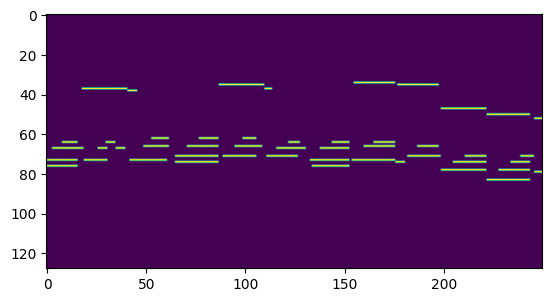

In [3]:
plt.imshow(X[15, 0, :, :])
plt.show()

In [4]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    mse = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD = 0 - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp()) + mse

    return reproduction_loss + KLD

In [5]:
class BachBlock(nn.Module):
    def __init__(self, heads=1):
        super().__init__()
        layers = []

        for head in range(heads):
            layers.append(nn.Conv2d(1, 84, kernel_size=(24, 24), padding='same'))
            layers.append(nn.ReLU())
            layers.append(nn.Conv2d(84, 64, kernel_size=(10, 10), padding='same'))
            layers.append(nn.ReLU())
            layers.append(nn.Conv2d(64, 1, kernel_size=(5, 5), padding='same'))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.1))

        self.mod = nn.Sequential(*layers)

    def forward(self, x):
        x = self.mod(x) + x
        return x


class BachVAE(nn.Module):
    def __init__(self):
        super(BachVAE, self).__init__()
        self.preprocessor = BachBlock(2)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(16, 16), stride=(4, 2)),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, kernel_size=(8, 8), stride=(2, 2)),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 2, kernel_size=(4, 4)),
            nn.LeakyReLU(0.2)
        )

        self.d1 = nn.Dropout(0.2)
        self.ztodec = nn.Linear(64, 1024)

        self.mean_layer = nn.Linear(848, 64)
        self.logvar_layer = nn.Linear(848, 64)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 256, kernel_size=(4, 7)),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(256, 256, kernel_size=(9, 13), stride=(2, 2)),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(256, 32, kernel_size=(16, 17), stride=(4, 2)),
            nn.Upsample(scale_factor=(1, 2)),
            nn.Conv2d(32, 1, kernel_size=6, padding='same'),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = self.d1(x)
        x = x.flatten(1)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, logvar):
        var = torch.exp(logvar)
        epsilon = torch.randn_like(var).to(device)
        z = mean + var * epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        # x = self.preprocessor(x)
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        z = self.ztodec(z)
        z = z.view(z.shape[0], 8, 8, 16)
        x_hat = self.decode(z)
        return x_hat, mean, logvar


model = BachVAE().to(device)
optim = Adam(model.parameters(), lr=0.001)
criterion = loss_function
twogpu = False
if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model).cuda()
        twogpu = True



In [15]:
model.train()
for epoch in range(10):
    for batch_idx, x in enumerate(dataloader):
        x = x.float().to(device)
        optim.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)

        loss.backward()
        optim.step()

    print(epoch, loss.item())

0 128182.859375
1 148107.5
2 150557.5
3 146556.40625
4 132804.296875
5 117659.609375
6 147992.828125
7 130227.625
8 118839.5625


KeyboardInterrupt: 

torch.Size([64, 1, 128, 250])


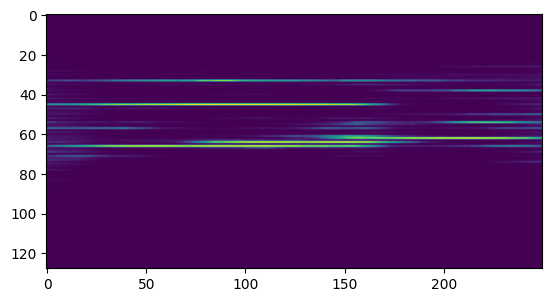

In [21]:
model.eval()
with torch.no_grad():
    _x = x.float().to(device)
    _x_hat, mean, log_var = model(_x)

_x_hat = _x_hat.cpu().numpy()[12, 0, :, :]
print(x_hat.shape)
plt.imshow(_x_hat)

# Generating Samples from learned Distribution

In [22]:
def generate_sample_distr(z_sample): # 8, 8, 16
    # z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    sample = x_decoded.detach().cpu().reshape(128, 100) # reshape vector to 2d array
    plt.imshow(sample)
    plt.axis('off')
    plt.show()
    return sample

0.9997713


['VAEpred2.pkl']

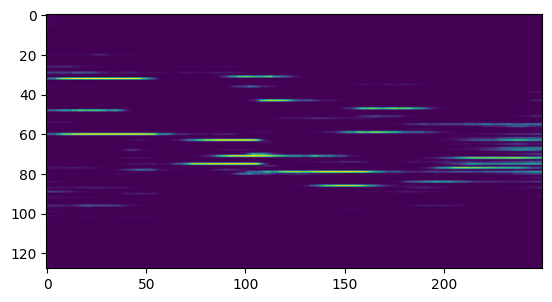

In [88]:
with torch.no_grad():
    mean = torch.randn(1, 64).to(device)*-0.1
    logvar = torch.randn(1, 64).to(device)*0.1
    z = model.reparameterization(mean, logvar)
    z = model.ztodec(z)
    z = z.view(z.shape[0], 8, 8, 16)
    new_sample = model.decode(z)

new_sample = new_sample.cpu().numpy()[0, 0, :, :]
print(new_sample.max())
plt.imshow(new_sample)

joblib.dump(new_sample, "VAEpred2.pkl")

### Per quanto è ancora molto basilare è promettente (credo)

In [24]:
def midi_to_audio(midi_path, fs=44100, outputfile="output.wav"):
    if isinstance(midi_path, str):
        midi_data = pretty_midi.PrettyMIDI(midi_path)
    else:
        midi_data = midi_path
    audio = midi_data.synthesize(fs=fs)
    scaled_audio = np.int16(audio / np.max(np.abs(audio)) * 32767)
    write(outputfile, 44100, scaled_audio)
    return audio
def multi_hot_to_midi(piano_roll: np.ndarray, time_per_step: float = 0.05,
                      velocity: int = 100) -> pretty_midi.PrettyMIDI:
    """
    Convert a multi-hot encoded piano roll (2D NumPy array with shape (T, 128)) into a PrettyMIDI object.

    Parameters:
      piano_roll (np.ndarray): 2D array of shape (T, 128) where each row is a binary (or multi-hot) vector.
      time_per_step (float): Duration (in seconds) of each time step. Default is 0.05 sec.
      velocity (int): Velocity for note on events. Default is 100.

    Returns:
      pretty_midi.PrettyMIDI: A MIDI object representing the piano roll.
    """
    T, n_pitches = piano_roll.shape
    if n_pitches != 128:
        raise ValueError("The input piano roll must have 128 columns (for MIDI notes 0-127).")

    # Create a new PrettyMIDI object and a single instrument (Acoustic Grand Piano)
    midi_obj = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)

    # Dictionary to keep track of active notes: pitch -> start time
    active_notes = {}

    # Iterate over time steps
    for t in range(T):
        current_time = t * time_per_step
        current_frame = piano_roll[t]  # shape: (128,)

        for pitch in range(128):
            is_active = current_frame[pitch] > 0
            # Check previous state: if first time step, assume note was off.
            prev_active = piano_roll[t - 1][pitch] > 0 if t > 0 else False

            # Note-on: the note is now active but wasn't active in the previous step.
            if is_active and not prev_active:
                active_notes[pitch] = current_time
            # Note-off: the note was active in the previous step but is now off.
            elif not is_active and prev_active:
                start_time = active_notes.pop(pitch, current_time)
                note = pretty_midi.Note(velocity=velocity, pitch=pitch, start=start_time, end=current_time)
                instrument.notes.append(note)

    # Close any notes still active at the end of the piano roll
    final_time = T * time_per_step
    for pitch, start_time in active_notes.items():
        note = pretty_midi.Note(velocity=velocity, pitch=pitch, start=start_time, end=final_time)
        instrument.notes.append(note)

    midi_obj.instruments.append(instrument)
    return midi_obj

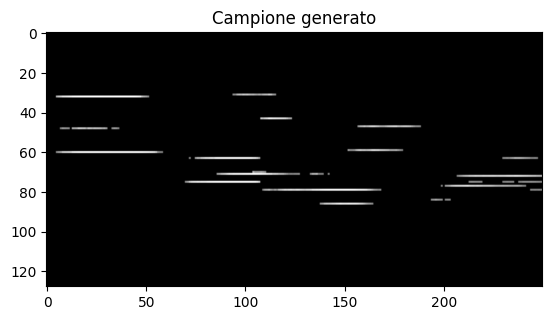

In [89]:
from scipy.io.wavfile import write

mel = new_sample
mel[mel > 1] = 1
mel[mel < 0.5] = 0
plt.imshow(mel, cmap='gray')
plt.title("Campione generato")
plt.show()

midi = multi_hot_to_midi(mel.T)
joblib.dump(midi, "pred.mid")
audio = midi_to_audio(midi)
import IPython
IPython.display.Audio(audio, rate=48_000)

In [ ]:
torch.save(model.state_dict(), "BachVAE2.pt")


In [ ]:
model.load_state_dict(torch.load("/kaggle/working/BachVAE1.pt", weights_only=True))
model.eval()